<h1>3. Exploratory Data Analysis </h1>

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import distance
from bs4 import BeautifulSoup

In [4]:
import time
import warnings
import sqlite3
#from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
from datetime import datetime as dt
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
import spacy
from tqdm import tqdm
from datetime import datetime as dt

<h2> 3.1 Reading data and basic stats </h2>

In [8]:
df = pd.read_csv("train.csv",engine='python',encoding='utf-8',error_bad_lines=False)

print("Number of data points:",df.shape[0])

Skipping line 241459: unexpected end of data


Number of data points: 241457


In [25]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241457 entries, 0 to 241456
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            241457 non-null  int64 
 1   qid1          241457 non-null  int64 
 2   qid2          241457 non-null  int64 
 3   question1     241457 non-null  object
 4   question2     241455 non-null  object
 5   is_duplicate  241457 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 11.1+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

<h3> 3.2.1 Distribution of data points among output classes</h3>
- Number of duplicate(similar) and non-duplicate(non similar) questions

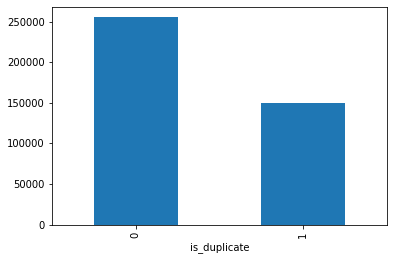

In [ ]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [14]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   241457


In [16]:
df.duplicated().sum()

0

In [23]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   62.79%

~> Question pairs are Similar (is_duplicate = 1):
   37.21%


<h3> 3.2.2 Number of unique questions </h3>

In [26]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 353463

Number of unique questions that appear more than one time: 60348 (17.073357041613974%)

Max number of times a single question is repeated: 89



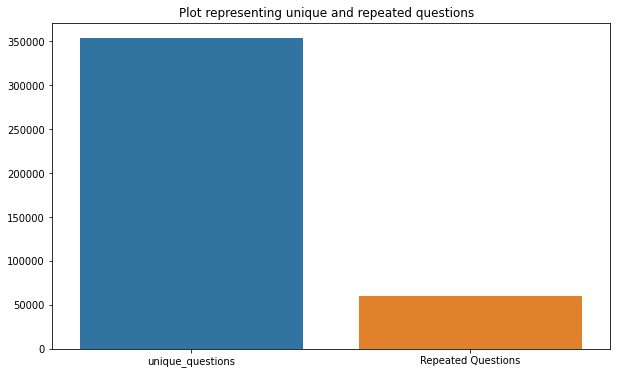

In [27]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

<h3>3.2.3 Checking for Duplicates </h3>

In [28]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


<h3> 3.2.4 Number of occurrences of each question </h3>

Maximum number of times a single question is repeated: 89



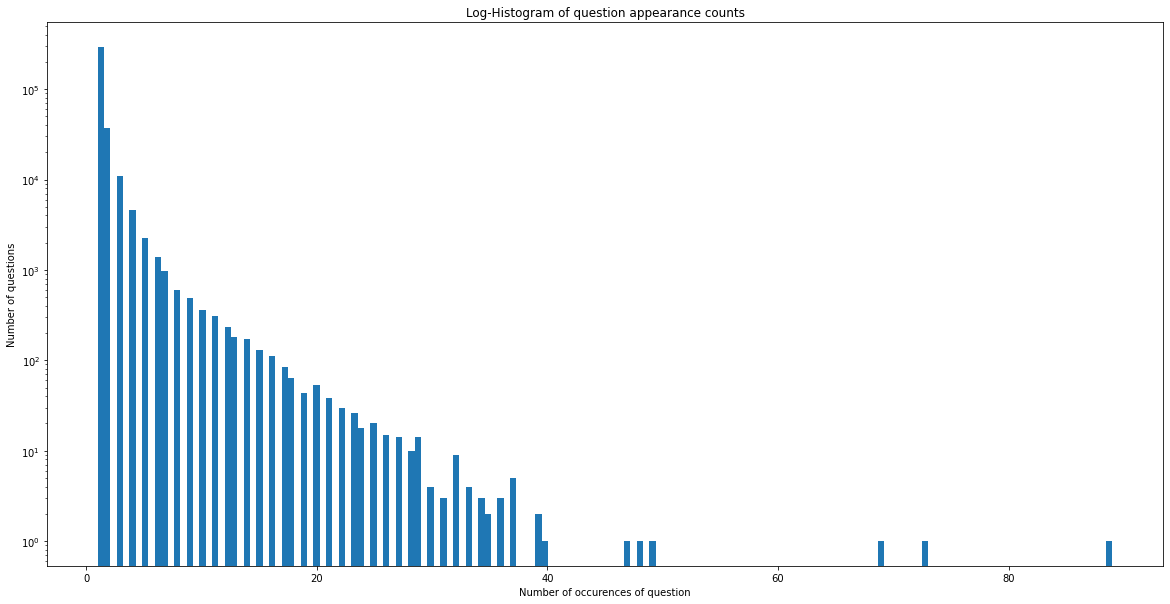

In [29]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

<h3> 3.2.5 Checking for NULL values </h3>

In [30]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1  ...  question2 is_duplicate
105780  105780  174363  ...        NaN            0
201841  201841  303951  ...        NaN            0

[2 rows x 6 columns]


- There are two rows with null values in question2 

In [31]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


<h2>3.3 Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [33]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,2,1,51,88,8,13,4.0,20.0,0.200000,3,1
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,2,1,76,39,13,7,2.0,20.0,0.100000,3,1


<h3> 3.3.1 Analysis of some of the extracted features </h3>

- Here are some questions have only one single words.

In [34]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 41
Number of Questions with minimum length [question2] : 19


<h4> 3.3.1.1 Feature: word_share </h4>

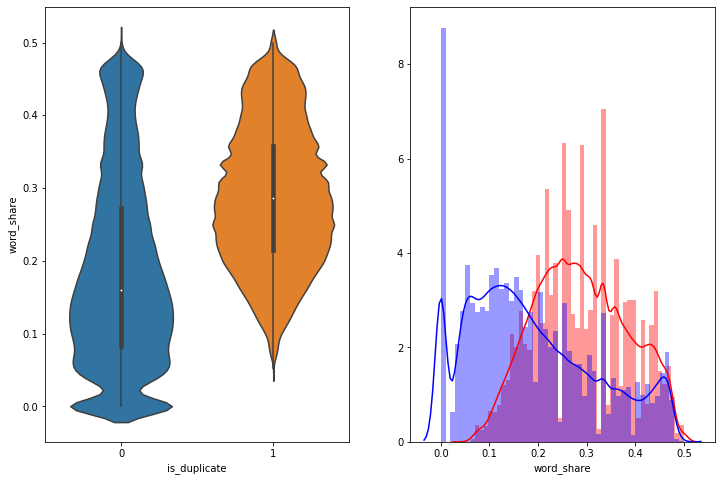

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h4> 3.3.1.2 Feature: word_Common </h4>

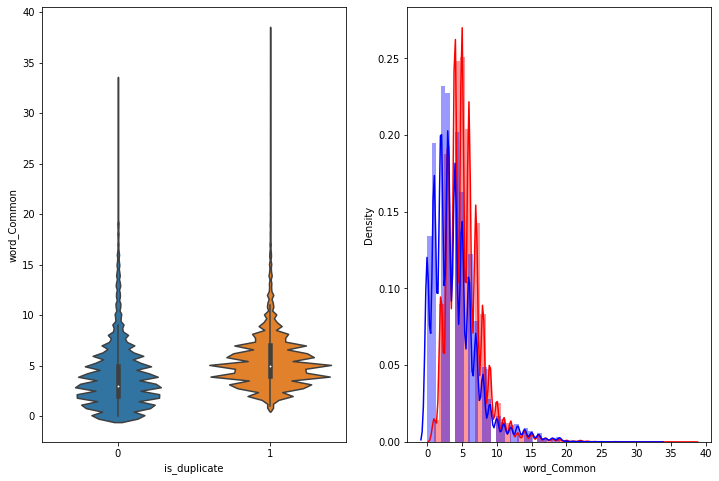

In [37]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

# 3.4 Preprocessing of Text

In [39]:
# To get the results in 4 decimal points
import nltk
nltk.download('stopwords')

SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 3.5 Advanced Feature Extraction (NLP and Fuzzy Features)

In [41]:
!pip install fuzzywuzzy

In [42]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
#import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
#import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [43]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [44]:
print("Extracting features for train:")
df = pd.read_csv("train.csv")
df = extract_features(df)
df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

Extracting features for train:
token features...
fuzzy features..


,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


# Analysis of extracted features 
##Plotting Word clouds

In [45]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s',encoding='utf-8')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s',encoding='utf-8')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [46]:
# reading the text files and removing the Stop Words:
from os import path
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt'), encoding="utf-8").read()
textn_w = open(path.join(d, 'train_n.txt'), encoding="utf-8").read()



stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16109886
Total number of words in non duplicate pair questions : 33193067


Word Cloud for Duplicate Question pairs


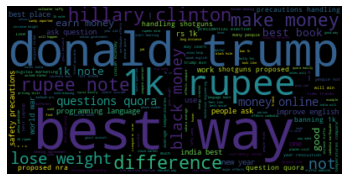

In [47]:
wc = WordCloud(background_color="black", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for non-Duplicate Question pairs:


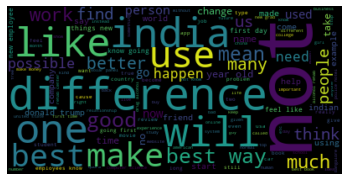

In [48]:
wc = WordCloud(background_color="black", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# 3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] 

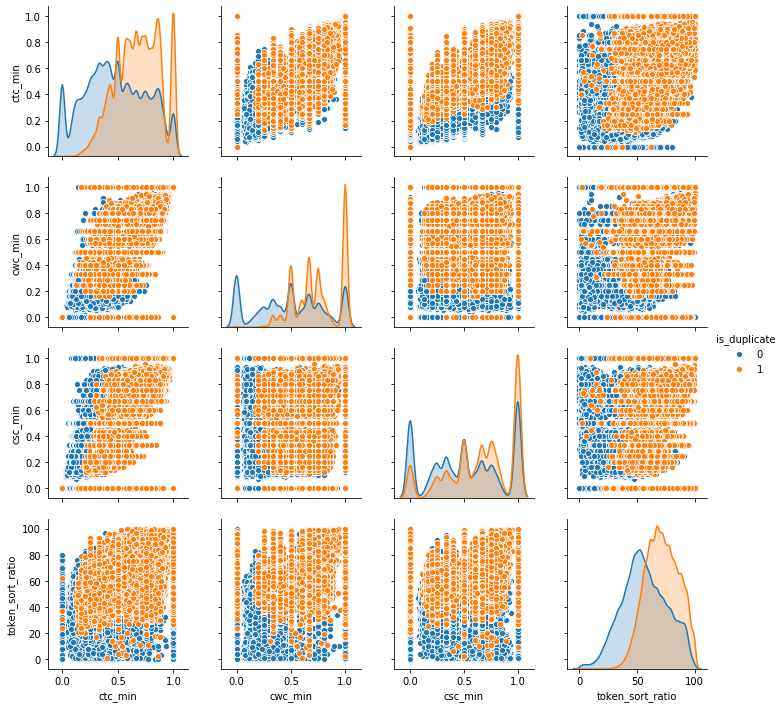

In [ ]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

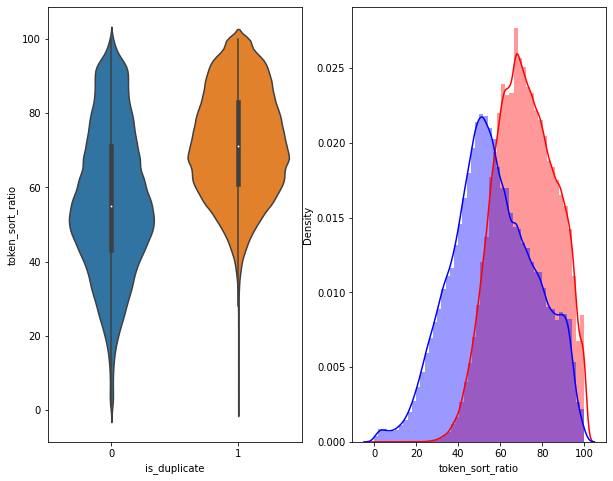

In [50]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

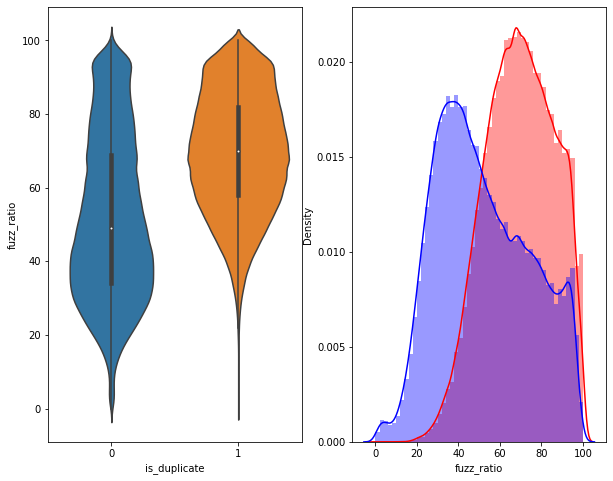

In [51]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

# 3.5.2 Visualization 

In [52]:
# Using TSNE for Dimensionality reduction for 15 Features(Generated after cleaning the data) to 3 dimension

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [53]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.032s...
[t-SNE] Computed neighbors for 5000 samples in 0.389s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.323s
[t-SNE] Iteration 50: error = 81.3346405, gradient norm = 0.0466835 (50 iterations in 2.500s)
[t-SNE] Iteration 100: error = 70.6411362, gradient norm = 0.0087385 (50 iterations in 1.740s)
[t-SNE] Iteration 150: error = 68.9421158, gradient norm = 0.0055224 (50 iterations in 1.692s)
[t-SNE] Iteration 200: error = 68.1217880, gradient norm = 0.0044136 (50 iterations in 1.712s)
[t-SNE] Iteration 250: error = 67.6154175, gradient norm = 0.0040027

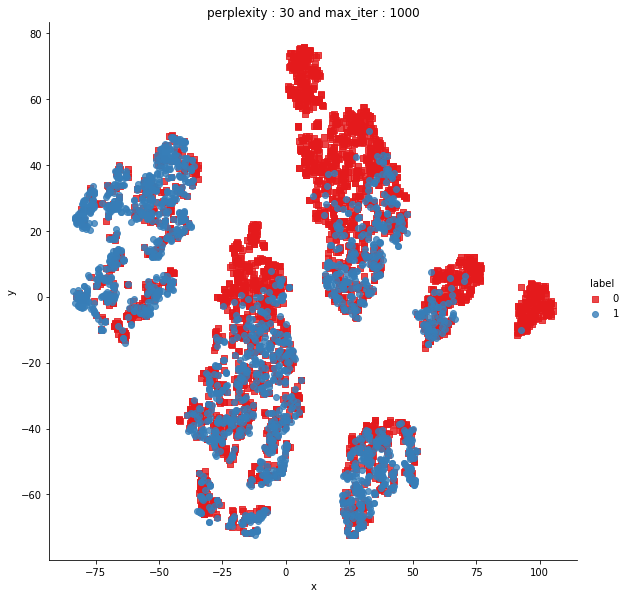

In [54]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [55]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.024s...
[t-SNE] Computed neighbors for 5000 samples in 0.390s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.312s
[t-SNE] Iteration 50: error = 80.5661621, gradient norm = 0.0296227 (50 iterations in 10.168s)
[t-SNE] Iteration 100: error = 69.4089432, gradient norm = 0.0033432 (50 iterations in 4.832s)
[t-SNE] Iteration 150: error = 67.9962845, gradient norm = 0.0018752 (50 iterations in 4.428s)
[t-SNE] Iteration 200: error = 67.4377289, gradient norm = 0.0011330 (50 iterations in 4.406s)
[t-SNE] Iteration 250: error = 67.1244202, gradient norm = 0.000859

In [56]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

# Featurizing text data with tfidf weighted word-vectors 

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as npx
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

In [58]:
df = pd.read_csv("train.csv")
 
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [59]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [60]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

CPU times: user 9.51 s, sys: 209 ms, total: 9.72 s
Wall time: 9.74 s


After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
here we use a pre-trained GLOVE model which comes free with "Spacy". https://spacy.io/usage/vectors-similarity
It is trained on Wikipedia and therefore, it is stronger in terms of word semantics.

In [ ]:
import en_core_web_sm
nlp=en_core_web_sm.load()

vecs=[]


In [61]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
import en_core_web_sm
nlp = en_core_web_sm.load()
#nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)


100%|██████████| 404290/404290 [1:05:59<00:00, 102.11it/s]


In [62]:
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

100%|██████████| 404290/404290 [1:06:12<00:00, 101.77it/s]


In [63]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro  = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')

In [64]:
#nlp_features_train.csv (NLP Features)
if os.path.isfile('train.csv'):
    dfnlp = pd.read_csv("train.csv",nrows=50000,encoding='latin-1')

In [72]:
# dataframe of nlp features
dfnlp.head(2)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0


In [73]:
# data before preprocessing 
dfppro.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,2,1,51,88,8,13,4.0,20.0,0.200000,3,1


In [74]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [75]:
# Questions 1 tfidf weighted word2vec
df3_q1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
0,-6.179507,37.450731,-67.929894,32.224274,143.348826,135.374574,17.865208,54.562352,81.618936,232.909839,27.167002,-6.187220,41.996069,-103.537911,-6.616976,-94.064813,-31.617267,-29.205890,-39.608413,30.163852,67.357976,56.346944,7.606743,20.720049,-56.899175,-41.419606,30.634747,-20.667785,93.049776,-108.506989,134.494691,-69.708587,57.891030,-94.501012,-34.043306,-88.044590,197.875458,-56.918224,-33.153865,-68.587951,...,114.638685,50.816876,-57.381595,106.554903,98.567380,-67.311119,88.728154,48.158799,-12.962363,-108.238607,77.740890,-76.930486,-55.488544,55.403322,-134.602412,15.887729,-14.812700,-43.172916,-71.213891,66.473449,138.864320,-134.555638,11.072384,11.770594,23.349589,-83.244351,-55.722126,-21.893210,8.263763,-14.915859,-71.834689,-60.222858,-22.026407,103.336720,-68.477445,-54.976584,-67.802663,116.269999,60.515897,-12.245916
1,9.236668,-80.371416,-45.785907,78.291656,183.568221,100.894077,74.344804,48.360802,127.297421,112.987302,73.449294,-47.164479,31.560610,-77.927155,-103.803116,-78.503396,11.997354,73.522302,-3.368269,-61.134586,1.137853,-47.250332,-14.747230,-111.214488,-92.936345,-86.908993,26.479862,-125.349442,53.630314,-118.244944,-19.311728,4.184269,37.147654,-32.207492,54.693156,-146.564649,190.351235,-50.185377,-102.660014,-62.070884,...,69.116646,123.042798,2.978409,-52.171842,-77.587376,-43.825259,-2.570918,25.001977,74.528037,55.402768,53.763126,-27.621300,-62.024373,67.296625,-127.672300,5.919581,51.888908,5.646263,-52.011487,-22.036677,150.269148,-19.587007,-46.445237,-12.489538,104.020920,-83.863392,-11.340908,26.339330,16.131961,137.782501,-32.130515,-98.080325,19.113790,-20.507508,-76.981011,82.665075,41.085582,129.377781,115.868467,4.383543
2,97.546829,22.972195,-39.558378,18.723416,56.928620,48.307643,8.719268,36.893737,106.899948,226.283080,-5.023025,-68.019793,-52.865684,-112.794187,49.411453,4.386397,-23.508985,3.867846,-19.287308,-52.332033,59.900114,102.718565,-6.070379,-47.957186,-51.316635,26.235306,-71.297170,-82.694041,61.166595,-59.661620,85.192997,95.725261,-9.786940,-44.572019,-26.737537,-8.913334,67.037574,-85.818559,-137.332815,-58.704829,...,126.969506,32.991508,11.751381,32.921630,127.876085,-117.452091,-53.697893,116.449840,-7.114503,-28.417017,22.236688,-95.365500,-13.684289,67.952175,-19.670386,0.049363,63.119457,21.524016,-36.342319,7.531785,101.659882,-90.213289,-11.944407,-20.185547,16.732628,9.608647,-77.976104,77.923826,59.257286,-78.643996,-66.835015,87.592131,4.032431,56.851709,-43.625410,-57.580963,-50.425829,78.591986,105.714348,-33.304161
3,57.586999,-22.017088,-4.599304,-88.939273,-4.732172,-54.209038,74.614942,106.533731,15.520623,39.009711,-101.132338,-12.242595,148.377723,101.759336,61.735411,147.720951,-76.666564,-61.303286,-63.827246,8.319557,-32.426865,-6.724337,-28.032162,-32.440859,25.425998,125.724761,5.593011,-111.110888,-10.119862,-23.430039,-38.038687,-19.025249,38.910990,-52.249356,-13.859811,-56.759533,19.452093,-96.299227,-86.240144,18.250540,...,99.160310,22.281756,-18.003228,20.443845,17.556030,-152.605936,-27.253293,2.113273,9.557493,-13.790257,-97.305417,11.291192,71.311880,20.816198,-23.316110,-17.823973,48.085230,30.902770,-5.960159,-99.039773,125.188415,-17.051089,-43.028228,79.045821,37.998520,-86.332762,-23.401571,55.163438,-13.930802,-25.005486,28.362956,41.981221,-11.204984,16.833434,-36.372471,8.927573,-64.553194,95.054238,-34.157566,70.821932
4,83.185784,-40.506985,-83.403923,-52.648658,79.074884,-19.038248,53.728722,97.648612,160.555822,290.541356,48.316273,28.484493,157.912918,-71.539273,62.088563,51.716923,-82.084056,-35.192773,-53.508376,-53.804667,124.787429,5.007129,-58.838039,-17.581073,-89.628781,21.836286,7.694493,-164.066897,159.268660,-92.885525,63.914158,82.922555,54.042456,-58.458466

In [76]:
# Questions 2 tfidf weighted word2vec
df3_q2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
0,-14.616981,59.755488,-53.263745,19.514497,113.916473,101.657056,8.561499,66.232769,32.888127,210.812733,-14.521656,5.732026,40.648458,-95.787979,-1.157125,-66.563451,-31.051373,-17.968147,-30.063745,32.889709,65.430540,54.742656,1.756501,27.786168,-46.373962,-25.822312,51.231668,-20.655695,98.152685,-96.048390,126.935466,-28.066691,82.523253,-91.751655,-24.696691,-67.690101,171.840663,-62.797236,-22.777055,-60.322768,...,120.843786,26.592192,-50.285062,114.594113,100.273874,-72.797047,85.467161,42.393031,-18.239859,-103.664753,68.317974,-46.449020,-60.184247,47.269530,-113.987847,10.320980,0.135103,-29.869163,-78.649177,77.262293,131.287160,-123.969027,20.822789,20.718112,38.093118,-85.086696,-61.891319,3.915410,-58.229361,-49.735812,-72.266625,-37.072086,-31.142730,94.064854,-45.053242,-34.155221,-76.548099,99.282776,50.791731,-17.566246
1,-3.565742,-16.844571,-130.911785,0.320254,79.350278,23.562028,79.124551,84.119839,128.684135,279.539877,51.329233,-47.977027,124.322700,-106.766716,-35.756386,-119.277429,21.692362,79.320570,-30.874480,-86.451965,-75.311001,-10.504030,-54.459205,-82.283126,-122.537507,-23.897150,38.062149,-120.668866,96.555255,-172.800629,71.174992,52.399280,-3.790546,-88.446559,-1.359644,-169.229485,242.162139,-106.348765,-118.454241,-81.356276,...,190.348300,114.510458,-79.321841,-65.284250,-69.147191,-111.427223,18.650104,15.329342,43.115542,31.039919,49.603525,-26.932295,-54.213027,98.597791,-72.848590,87.272756,2.563240,-12.326506,-50.862417,19.058227,180.085690,-79.230389,-49.612403,-2.875509,12.640813,-205.569995,-46.432224,86.927369,2.640828,-2.350201,6.193171,-65.084229,-15.654534,-3.475828,26.999802,170.172613,-57.038953,194.269546,128.207803,55.490061
2,156.833630,59.991896,-8.414311,29.251426,133.680218,112.457566,89.849781,21.613022,24.331766,171.114490,-104.683288,-27.202060,-45.827002,-96.844532,-12.986917,43.818585,20.793440,15.393396,0.015373,-28.024086,-12.633978,11.869804,-52.478160,-3.826736,8.331102,21.353006,-36.579113,-14.109747,43.868416,-107.133660,125.654210,-0.800086,39.060021,-50.904144,37.683092,-78.781466,122.383833,-67.524980,-107.706957,-19.469239,...,13.483461,-63.411094,40.414527,37.971310,110.463600,-76.722634,-13.193802,38.792827,-49.570232,-142.726638,12.245693,-54.343166,-60.057482,102.482628,3.656340,-21.436032,37.960952,-25.729971,23.332562,9.404027,153.432356,-76.191487,-20.813622,-27.269100,11.735237,-20.692981,-47.580536,42.119569,49.291951,-59.756461,-26.185226,-19.283218,75.602438,24.144027,-91.874398,-178.454113,-91.471482,19.922719,21.266690,49.574858
3,41.472439,56.717317,31.530616,-5.520164,33.454800,79.596179,15.508996,40.042066,21.094017,101.998116,-70.692718,-62.091010,-21.603829,-52.963033,-6.126429,23.129693,-39.828342,-7.557531,10.800786,12.595844,32.663719,-36.700902,-20.552382,-7.180278,-32.160210,28.720635,-42.108100,-63.517539,36.148466,3.026077,-8.988254,64.167554,33.157036,-21.770225,-14.935299,0.127441,61.023365,-50.604968,-81.644456,-43.092263,...,42.726956,10.111637,15.897465,30.342897,42.910006,-101.291523,30.792590,-33.975097,-68.384557,-21.621304,20.336738,18.368145,-2.009289,46.823555,14.814505,84.138001,59.194556,-36.240492,30.679147,-0.383225,48.515156,-53.941062,-25.314894,-6.555996,-48.458986,-34.730500,24.471891,81.124125,-26.392446,-64.587732,-17.779019,30.152297,49.300137,27.783795,25.937188,-32.107076,-3.817634,-14.231000,4.772115,7.711628
4,-14.446975,-4.338255,-70.196208,-48.636382,18.356858,-50.807069,24.311196,60.043674,32.421993,57.148702,-39.954876,-1.186079,103.167159,-60.704754,8.761264,27.956269,11.443861,-44.191169,-44.108188,49.248302,18.939539,29.493630,-19.378594,3.728311,-41.595879,6.727060,46.843683,-32.771427,52.378441,-32.777207,73.263024,12.407717,35.007572,-44.449785,-1.699862,-68.

In [77]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 w2v  dataframe :", df3_q1.shape[1])
print("Number of features in question2 w2v  dataframe :", df3_q2.shape[1])
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])

Number of features in nlp dataframe : 2
Number of features in preprocessed dataframe : 12
Number of features in question1 w2v  dataframe : 96
Number of features in question2 w2v  dataframe : 96
Number of features in final dataframe  : 206


In [78]:
# storing the final features to csv file
if not os.path.isfile('final_features.csv'):
    df3_q1['id']=df1['id']
    df3_q2['id']=df1['id']
    df1  = df1.merge(df2, on='id',how='left')
   # df2  = df3_q1.merge(df3_q2, on='id',how='left')
    result  = df1.merge(df2, on='id',how='left')
    result.to_csv('final_features.csv')

# 4. Machine Learning Models 

# 4.1 Reading data from file and storing into sql table

In [79]:
if os.path.isfile('final_features.csv'):
    data = pd.read_csv('final_features.csv',nrows=50000,encoding='utf-8')

In [80]:

data.head(3)

,Unnamed: 0,id,is_duplicate,freq_qid1_x,freq_qid2_x,q1len_x,q2len_x,q1_n_words_x,q2_n_words_x,word_Common_x,word_Total_x,word_share_x,freq_q1+q2_x,freq_q1-q2_x,freq_qid1_y,freq_qid2_y,q1len_y,q2len_y,q1_n_words_y,q2_n_words_y,word_Common_y,word_Total_y,word_share_y,freq_q1+q2_y,freq_q1-q2_y
0,0,0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,1,0,2,1,51,88,8,13,4.0,20.0,0.200000,3,1,2,1,51,88,8,13,4.0,20.0,0.200000,3,1
2,2,2,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0


# 4.3 Random train test split

In [81]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data,data['is_duplicate'],stratify=data['is_duplicate'], random_state=32)

In [82]:
X_train.shape

(37500, 25)

In [83]:
X_train.head(2)

,Unnamed: 0,id,is_duplicate,freq_qid1_x,freq_qid2_x,q1len_x,q2len_x,q1_n_words_x,q2_n_words_x,word_Common_x,word_Total_x,word_share_x,freq_q1+q2_x,freq_q1-q2_x,freq_qid1_y,freq_qid2_y,q1len_y,q2len_y,q1_n_words_y,q2_n_words_y,word_Common_y,word_Total_y,word_share_y,freq_q1+q2_y,freq_q1-q2_y
23561,23561,23561,0,1,1,33,50,7,10,4.0,17.0,0.235294,2,0,1,1,33,50,7,10,4.0,17.0,0.235294,2,0
3536,3536,3536,0,1,1,46,58,10,12,1.0,22.0,0.045455,2,0,1,1,46,58,10,12,1.0,22.0,0.045455,2,0


In [84]:
# extraction  features from train  data frame 
X_train = X_train.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=False)

# extraction  features from test data frame 
X_test = X_test.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=False)

print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (37500, 22)
Number of data points in test data : (12500, 22)


In [85]:
y_train.shape

(37500,)

In [89]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6270133333333333 Class 1:  0.3729866666666667
---------- Distribution of output variable in test data ----------
Class 0:  0.62704 Class 1:  0.37296


In [90]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

# 4.4 Building a random model (Finding worst-case log-loss) 

Log loss on Test Data using Random Model 0.8788373475422782


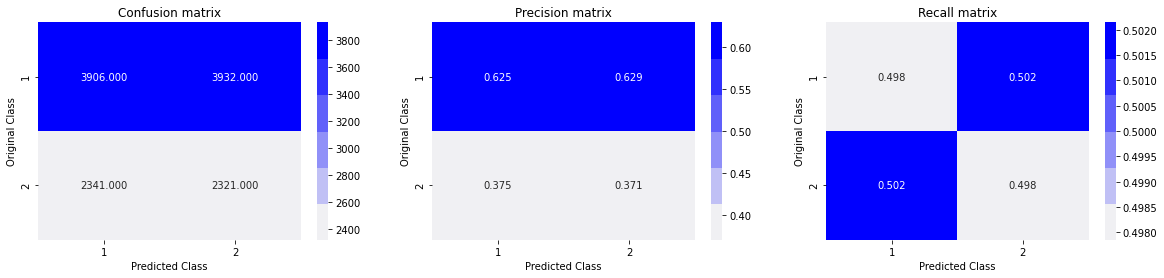

In [91]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

# 4.4 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.46748950473787415
For values of alpha =  0.0001 The log loss is: 0.467411411795257
For values of alpha =  0.001 The log loss is: 0.4702043503620991
For values of alpha =  0.01 The log loss is: 0.47095651464973903
For values of alpha =  0.1 The log loss is: 0.47815931432174075
For values of alpha =  1 The log loss is: 0.47883932764652315
For values of alpha =  10 The log loss is: 0.5087726243467064


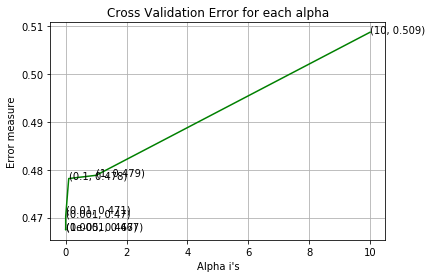

For values of best alpha =  0.0001 The train log loss is: 0.4658529781704176
For values of best alpha =  0.0001 The test log loss is: 0.467411411795257
Total number of data points : 12500


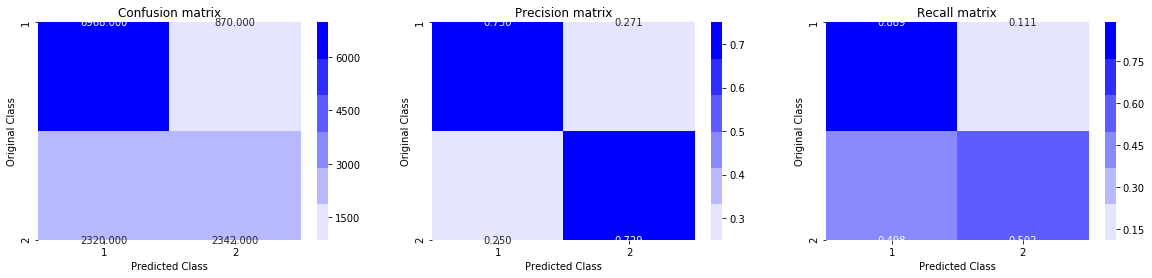

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.




log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# 4.5 Linear SVM with hyperparameter tuning 

For values of alpha =  1e-05 The log loss is: 0.468568715140383
For values of alpha =  0.0001 The log loss is: 0.4836764509430551
For values of alpha =  0.001 The log loss is: 0.49419792841068927
For values of alpha =  0.01 The log loss is: 0.5181667966968087
For values of alpha =  0.1 The log loss is: 0.47892462615236553
For values of alpha =  1 The log loss is: 0.583450288631332
For values of alpha =  10 The log loss is: 0.6384048153029616


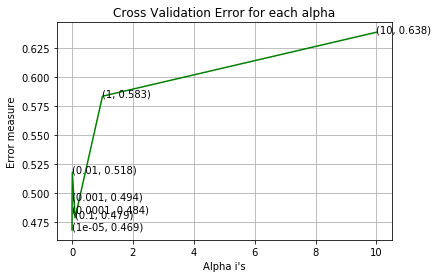

For values of best alpha =  1e-05 The train log loss is: 0.46792983199906313
For values of best alpha =  1e-05 The test log loss is: 0.468568715140383
Total number of data points : 12500


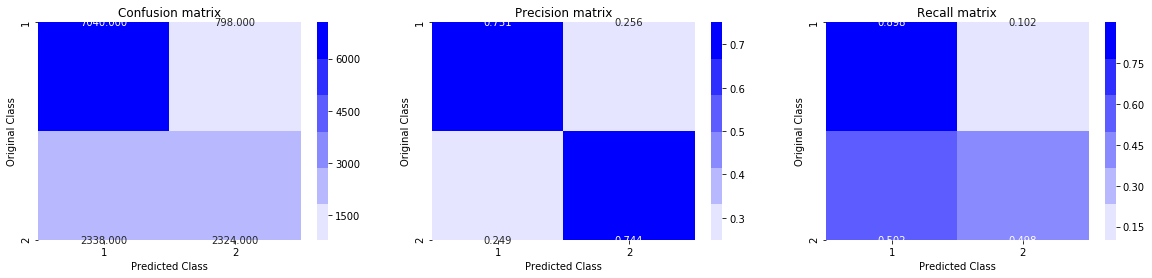

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.




log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# 4.6 XGBoost 

In [ ]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.685301	valid-logloss:0.685242
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.620617	valid-logloss:0.620098
[20]	train-logloss:0.573226	valid-logloss:0.572814
[30]	train-logloss:0.537786	valid-logloss:0.537428
[40]	train-logloss:0.511344	valid-logloss:0.51081
[50]	train-logloss:0.490437	valid-logloss:0.489951
[60]	train-logloss:0.475004	valid-logloss:0.47453
[70]	train-logloss:0.462591	valid-logloss:0.462188
[80]	train-logloss:0.452563	valid-logloss:0.452189
[90]	train-logloss:0.4443	valid-logloss:0.443862
[100]	train-logloss:0.437586	valid-logloss:0.437173
[110]	train-logloss:0.432111	valid-logloss:0.431734
[120]	train-logloss:0.427581	valid-logloss:0.427275
[130]	train-logloss:0.423936	valid-logloss:0.423784
[140]	train-logloss:0.420928	valid-logloss:0.420948
[150]	train-logloss:0.418488	valid-logloss:0.418605
[160]	train-logloss:0.416269	val

Total number of data points : 12500


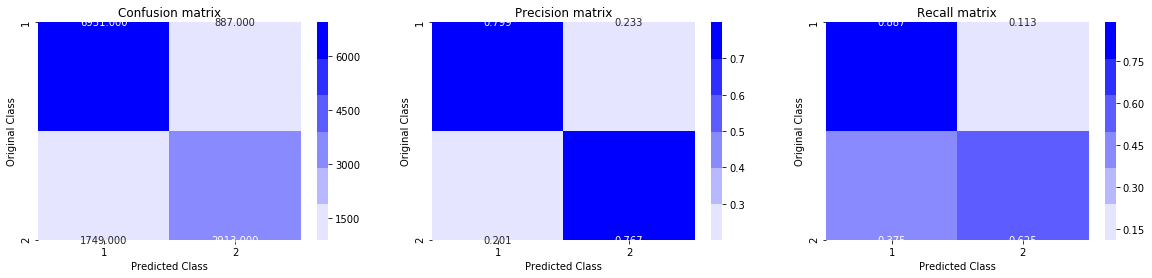

In [ ]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

1. Let us Try out models (Logistic regression, Linear-SVM) with simple TF-IDF vectors instead of TD_IDF weighted word2Vec.
2. Hyperparameter tune XgBoost using RandomSearch to reduce the log-loss.


# 5.1 Reading data from file

In [92]:
if os.path.isfile('nlp_features_train.csv'):
    df1 = pd.read_csv("nlp_features_train.csv",nrows=50000,encoding='latin-1')

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')

In [93]:
df1.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [94]:
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
dfnlp = df1.merge(df2, on='id',how='left')

In [95]:
dfnlp.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154,2,1,51,88,8,13,4.0,20.0,0.200000,3,1


In [96]:
nan_rows = dfnlp[dfnlp.isnull().any(1)]
print (nan_rows)

          id   qid1   qid2  ... word_share freq_q1+q2  freq_q1-q2
3306    3306   6553   6554  ...        0.0          2           0
13016  13016  25026  25027  ...        0.0          3           1
20072  20072  37898  37899  ...        0.0          2           0
20794  20794  39204  39205  ...        0.0          2           0
47056  47056  84067  84068  ...        0.0          3           1

[5 rows x 32 columns]


In [97]:
# Filling the null values with ' '
dfnlp = dfnlp.fillna('')
nan_rows = dfnlp[dfnlp.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate, cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio, freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_Common, word_Total, word_share, freq_q1+q2, freq_q1-q2]
Index: []


# 5.2 Splitting data into Train and cross validation(or test): Stratified Sampling

In [98]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dfnlp,dfnlp['is_duplicate'],stratify=dfnlp['is_duplicate'], random_state=32)


In [99]:
X_train= X_train.drop(('is_duplicate'),axis=1)
X_train.shape

(37500, 31)

In [100]:
y_train.shape

(37500,)

In [101]:
y_test.shape

(12500,)

In [102]:
X_test= X_test.drop(('is_duplicate'),axis=1)
X_test.shape

(12500, 31)

In [103]:
X_train.head()

,id,qid1,qid2,question1,question2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
23561,23561,44124,44125,how do i learn geography for nda,how do i learn to accept myself and my appeara...,0.333322,0.333322,0.749981,0.428565,0.571420,0.399996,0.0,1.0,3.0,8.5,61,37,47,52,0.441176,1,1,33,50,7,10,4.0,17.0,0.235294,2,0
3536,3536,7006,7007,what happens when 0 gb disk space is reached,is there a pokemon fan game or romhack set dur...,0.000000,0.000000,0.333322,0.166664,0.111110,0.083333,0.0,0.0,3.0,10.5,32,44,16,23,0.063830,1,1,46,58,10,12,1.0,22.0,0.045455,2,0
33192,33192,61018,19621,why do people ask so many googleable questions...,why do some people ask questions on quora that...,0.666656,0.399996,0.749981,0.374995,0.699993,0.388887,0.0,1.0,8.0,14.0,79,60,48,66,0.350877,19,16,56,97,10,18,6.0,28.0,0.214286,35,3
35725,35725,65244,65245,what is china doing to help nepal,how can we help nepal,0.999950,0.666644,0.000000,0.000000,0.399992,0.285710,1.0,0.0,2.0,6.0,65,59,59,64,0.521739,1,1,34,22,7,5,2.0,12.0,0.166667,2,0
6320,6320,12389,12390,what are the best education portals in india,which are the best sites for free education in...,0.749981,0.599988,0.749981,0.599988,0.749991,0.599994,1.0,0.0,2.0,9.0,83,77,71,67,0.304348,2,1,45,53,8,10,6.0,18.0,0.333333,3,1


# 5.3 TFIDF vectorizer on Questions Text Data

In [104]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=10)

# merge texts
questions = list(X_train['question1']) + list(X_train['question2'])

vectorizer.fit(questions)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=10, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

# Train Data

In [105]:
tfidf_train_ques1= vectorizer.transform(X_train['question1'])
print("Shape of matrix after one hot encodig ",tfidf_train_ques1.shape)

print("the number of unique words ", tfidf_train_ques1.get_shape()[1])



Shape of matrix after one hot encodig  (37500, 13369)
the number of unique words  13369


In [106]:
tfidf_train_ques2= vectorizer.transform(X_train['question2'])
print("Shape of matrix after one hot encodig ",tfidf_train_ques2.shape)
print("the number of unique words ", tfidf_train_ques2.get_shape()[1])


Shape of matrix after one hot encodig  (37500, 13369)
the number of unique words  13369


In [107]:
# extraction  features from train  data frame 
X_train_feature_df = X_train.drop(['id','qid1','qid2','question1','question2'], axis=1, inplace=False)

In [108]:
X_train_feature_df.head(2)

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
23561,0.333322,0.333322,0.749981,0.428565,0.57142,0.399996,0.0,1.0,3.0,8.5,61,37,47,52,0.441176,1,1,33,50,7,10,4.0,17.0,0.235294,2,0
3536,0.000000,0.000000,0.333322,0.166664,0.11111,0.083333,0.0,0.0,3.0,10.5,32,44,16,23,0.063830,1,1,46,58,10,12,1.0,22.0,0.045455,2,0


In [109]:
import scipy
# X_train.head()
print("train Shape Before -> ",X_train_feature_df.shape," Type",type(X_train_feature_df))

#we need to convert the feature data into sparse matrix so that we can combine our features and  tfidf vec 
train_feat_sparse = scipy.sparse.csr_matrix(X_train_feature_df)

print("train Shape After-> ",train_feat_sparse.shape," Type",type(train_feat_sparse))

train Shape Before ->  (37500, 26)  Type <class 'pandas.core.frame.DataFrame'>
train Shape After->  (37500, 26)  Type <class 'scipy.sparse.csr.csr_matrix'>


# TEST Data

In [110]:
tfidf_test_ques1= vectorizer.transform(X_test['question1'])
print("Shape of matrix after one hot encodig ",tfidf_test_ques1.shape)
print("the number of unique words ", tfidf_test_ques1.get_shape()[1])


tfidf_test_ques2= vectorizer.transform(X_test['question2'])
print("Shape of matrix after one hot encodig ",tfidf_test_ques2.shape)
print("the number of unique words ", tfidf_test_ques2.get_shape()[1])

Shape of matrix after one hot encodig  (12500, 13369)
the number of unique words  13369
Shape of matrix after one hot encodig  (12500, 13369)
the number of unique words  13369


In [111]:
# extraction  features from test  data frame 
X_test_feature_df = X_test.drop(['id','qid1','qid2','question1','question2'], axis=1, inplace=False)


print("test Shape Before -> ",X_test_feature_df.shape," Type",type(X_test_feature_df))

#so we need to convert our feature data into sparse matrix so that we will combine our feature and and tfidf vec 
test_feat_sparse = scipy.sparse.csr_matrix(X_test_feature_df)

print("test Shape After-> ",test_feat_sparse.shape," Type",type(test_feat_sparse))

test Shape Before ->  (12500, 26)  Type <class 'pandas.core.frame.DataFrame'>
test Shape After->  (12500, 26)  Type <class 'scipy.sparse.csr.csr_matrix'>


In [112]:
# combining our tfidf and features into one 

# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack


tfidf_train = hstack((tfidf_train_ques1,tfidf_train_ques2))

# test features(feat + tfidfvec)
tfidf_test = hstack((tfidf_test_ques1,tfidf_test_ques2))

#final train and test data shape 
print("train data shape",tfidf_train.shape)

print("Test data shape ",tfidf_test.shape)

train data shape (37500, 26738)
Test data shape  (12500, 26738)


In [113]:
tfidf_train.shape

(37500, 26738)

In [114]:
from scipy.sparse import hstack

tfidf_train = hstack((train_feat_sparse,tfidf_train_ques1,tfidf_train_ques2))

# test features(feat + tfidfvec)
tfidf_test = hstack((test_feat_sparse,tfidf_test_ques1,tfidf_test_ques2))

#final train and test data shape 
print("train data shape",tfidf_train.shape)

print("Test data shape ",tfidf_test.shape)

train data shape (37500, 26764)
Test data shape  (12500, 26764)


In [115]:
print("Final Shape of the Data matrix")
print(tfidf_train.shape, y_train.shape)

print(tfidf_test.shape, y_test.shape)

Final Shape of the Data matrix
(37500, 26764) (37500,)
(12500, 26764) (12500,)


In [117]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6270133333333333 Class 1:  0.3729866666666667
---------- Distribution of output variable in test data ----------
Class 0:  0.62704 Class 1:  0.37296


# 5.4 Logistic Regression with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.43243610251165965
For values of alpha =  0.0001 The log loss is: 0.4420792846640858
For values of alpha =  0.001 The log loss is: 0.4427199998389551
For values of alpha =  0.01 The log loss is: 0.4711340724303233
For values of alpha =  0.1 The log loss is: 0.47961386720378796
For values of alpha =  1 The log loss is: 0.5096511886344345
For values of alpha =  10 The log loss is: 0.5548481195855373


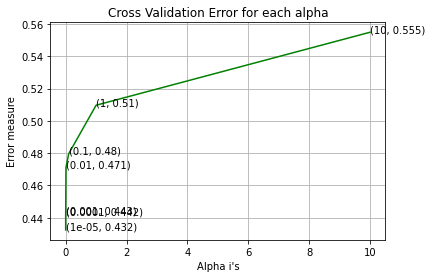

For values of best alpha =  1e-05 The train log loss is: 0.4215926602025094
For values of best alpha =  1e-05 The test log loss is: 0.43243610251165965
Total number of data points : 12500


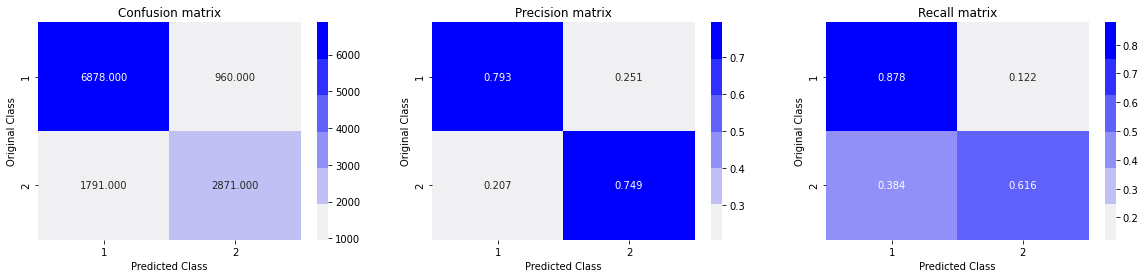

In [120]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=�hinge�, penalty=�l2�, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=�optimal�, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, �])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(tfidf_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(tfidf_train, y_train)
    predict_y = sig_clf.predict_proba(tfidf_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(tfidf_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(tfidf_train, y_train)

predict_y = sig_clf.predict_proba(tfidf_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(tfidf_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# 5.5 Linear SVM with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.44055060308003713
For values of alpha =  0.0001 The log loss is: 0.4739964863198457
For values of alpha =  0.001 The log loss is: 0.4861788835774691
For values of alpha =  0.01 The log loss is: 0.5196767681537059
For values of alpha =  0.1 The log loss is: 0.48887010386648644
For values of alpha =  1 The log loss is: 0.5751288906659099
For values of alpha =  10 The log loss is: 0.6316597464583033


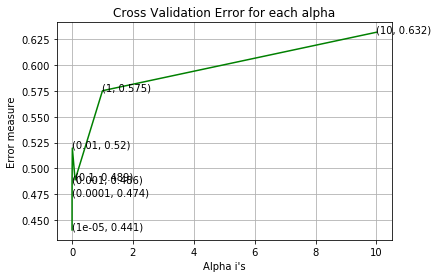

For values of best alpha =  1e-05 The train log loss is: 0.42745588054917155
For values of best alpha =  1e-05 The test log loss is: 0.44055060308003713
Total number of data points : 12500


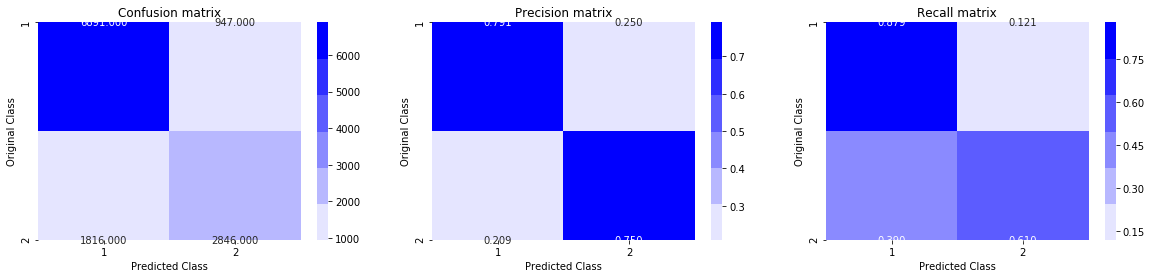

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=�hinge�, penalty=�l2�, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=�optimal�, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, �])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.



log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(tfidf_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(tfidf_train, y_train)
    predict_y = sig_clf.predict_proba(tfidf_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(tfidf_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(tfidf_train, y_train)

predict_y = sig_clf.predict_proba(tfidf_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(tfidf_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# 5.6 XGBoost

# A. Hyperparameter Tuning

In [123]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as sc



params = {
        
        "learning_rate":sc.uniform(0.05,0.3),
        'max_depth': sc.randint(3,15),
        'n_estimators' : sc.randint(10,200),
        "min_child_weight" : [ 1, 3, 5, 7 ],
        'gamma': sc.uniform(0.0,0.5)
        }
x_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss',n_jobs=-1)

xgb_random_search = RandomizedSearchCV(x_model, param_distributions = params,n_iter=30,
                         scoring = 'neg_log_loss', n_jobs = -1,cv=3)

xgb_random_search.fit(tfidf_train, y_train)


print("Score : ",xgb_random_search.best_score_)
print("Best Params",xgb_random_search.best_params_)

Score :  -0.3497625287179327
Best Params {'gamma': 0.12526728798377457, 'learning_rate': 0.08528144281663791, 'max_depth': 12, 'min_child_weight': 7, 'n_estimators': 161}


# B. With Best Params

The train log loss is:  0.2483836581900135
The test log loss is :  0.3533921714478344


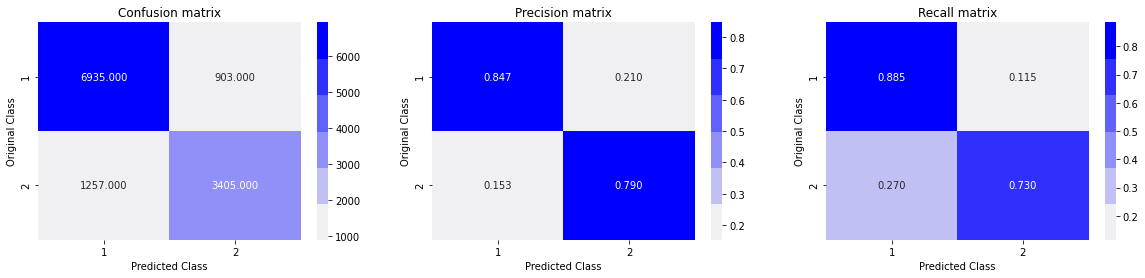

In [124]:
bst = xgb.XGBClassifier(max_depth=12,learning_rate= 0.08528144281663791,objective='binary:logistic',gamma=0.12526728798377457,n_estimators=161,min_child_weight=7,n_jobs=-1)
bst.fit(tfidf_train, y_train)   


clf_calib = CalibratedClassifierCV(bst, method="sigmoid")
clf_calib.fit(tfidf_train, y_train)

predict_y = clf_calib.predict_proba(tfidf_train)

print("The train log loss is: ",log_loss(y_train, predict_y,labels=bst.classes_, eps=1e-15))

predict_y = clf_calib.predict_proba(tfidf_test)
print("The test log loss is : ",log_loss(y_test, predict_y,labels=bst.classes_, eps=1e-15))


predicted_y =np.argmax(predict_y,axis=1)
plot_confusion_matrix(y_test, predicted_y)

# Conclusions And Observations:

In [125]:
from prettytable import PrettyTable
ptable = PrettyTable()
ptable.title = " Model Comparision "
ptable.field_names = ['Serial No.', 'Model Name', 'Tokenizer','Hyperparameter Tunning', 'Test Log Loss']
ptable.add_row(["1","Random","TFIDF Weighted W2V","-","0.89"])
ptable.add_row(["2","Logistic Regression","TFIDF Weighted W2V","Done","0.468"])
ptable.add_row(["3","Linear SVM","TFIDF Weighted W2V","Done","0.474"])
ptable.add_row(["4","XGBoost","TFIDF Weighted W2V","-","0.399"])
ptable.add_row(["\n","\n","\n","\n","\n"])
ptable.add_row(["1","Random","TFIDF","-","0.89"])
ptable.add_row(["2","Logistic Regression","TFIDF","Done","0.432"])
ptable.add_row(["3","Linear SVM","TFIDF","Done","0.440"])
ptable.add_row(["4","XGBoost","TFIDF","Done","0.353"])
print(ptable)

+------------+---------------------+--------------------+------------------------+---------------+
| Serial No. |      Model Name     |     Tokenizer      | Hyperparameter Tunning | Test Log Loss |
+------------+---------------------+--------------------+------------------------+---------------+
|     1      |        Random       | TFIDF Weighted W2V |           -            |      0.89     |
|     2      | Logistic Regression | TFIDF Weighted W2V |          Done          |     0.468     |
|     3      |      Linear SVM     | TFIDF Weighted W2V |          Done          |     0.474     |
|     4      |       XGBoost       | TFIDF Weighted W2V |           -            |     0.399     |
|            |                     |                    |                        |               |
|            |                     |                    |                        |               |
|     1      |        Random       |       TFIDF        |           -            |      0.89     |
|     2   

# STEP BY STEP PROCEDURE:

1.Our Data contains 5 columns : qid1, qid2, question1, question2, is_duplicate from which 'is_duplicate' is a class label which specifies whether the question 1 and question 2 are similar or not and this is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not.
    
    
2.Firstly we preprocessed our data,did feature engineering to create new features which might help us and created our dataframes, then we merged dataframes and got out final matrix.Now after doing simple EDA on dataset we will try some Basic Feature Extraction (before cleaning) the datset like Frequency of qid1's ,word_Common and etc. and using this featured datset we will do some EDA on it so that we will able to rectify which features are most useful features our of all features i.e(wich feature is helpful for classification)


3.After doing basic Basic feature extractions we will try some Advanced Feature Extraction using NLP and Fuzzy Features but before doing this we will do Preprocessing of Text and then we will do Advanced Feature Extraction and try to visualise our Advanced Feature using EDA, PCA and word clouds.


4.Then we Split the  data randomly . We could also have done time based splitting, since the model could predict for future unseen data too. But, there was no timestamp column provided, so the only option was to split it randomly.


5.Now as we know we have columns of two questions i.e question 1 and question 2 and we will vectorize that both col using tfidf weighted word-vectors so that we will able to apply models on it and after doing all these we will merge all the features i.e besic features + advance features + question1 tfidf w2v + and question 2 tfidf w2v. and Now after doing all of there we will apply models on it.


6.Here as we know here we are using two main performance matrix in this case study i.e log-loss and confusion matrix and using there we will get our performsnce of the models


7.Lets start: here we are there model i.e Logistic Regression linear svm and XgBoost and a random model which Finding worst-case log-loss and then we try to comparse all


8.In next step we will try our models with other vectorizer i.e tfidf instead of tfidf weighted w2v and try to do some hyperparameter tuning in order to improve the model performance.


9.Now, we have applied simple Random/Dumb Model. It gave a log loss of 0.89. This is the worst case log-loss. This will act as a base and any model we design should have a log-loss lesser than this dumb model.


10.After that we have applied Logistic Regression with hyperparameter tuning. It gave a log-loss of 0.43, which is lower than Random Model. We can also see that there is no Overfitting problem , since, Train log-loss and Test log-loss and very close.


11.After that we have applied Linear SVM with hyperparameter tuning. It gave the log-loss of 0.44,which is lower than Random Model. We can also see that there is no Overfitting problem , since, Train log-loss and Test log-loss and very close.


12.After that we have applied Xgboost with hyperparameter tuning. It gave the log-loss of 0.34,which is lower than Random Model. We can also see that there is no Overfitting problem , since, Train log-loss and Test log-loss and very close.



Looks like among all the models that we tried Xgboost seems to perform well and hence can be used to Identify which questions asked on Quora are duplicates of questions that have already been asked.